# Achieved 93.652% Private Score and 86.057% Public Score on Test Data After Submission

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import os
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import glob
from sklearn.utils.class_weight import compute_class_weight

2025-07-15 12:06:33.398421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752581193.769943      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752581193.877102      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading & Reading Train Images

In [ ]:
df_train = pd.read_csv('/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv')
df_train.head()

,filename,label
0,39d30b68.jpg,Naeimi
1,4a9853bd.jpg,Goat
2,d88facaa.jpg,Roman
3,a3f4f4af.jpg,Roman
4,16b31730.jpg,Naeimi


In [ ]:
df_train['image_path'] = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train/' + df_train['filename']
df_train.head()

,filename,label,image_path
0,39d30b68.jpg,Naeimi,/kaggle/input/sheep-classification-challenge-2...
1,4a9853bd.jpg,Goat,/kaggle/input/sheep-classification-challenge-2...
2,d88facaa.jpg,Roman,/kaggle/input/sheep-classification-challenge-2...
3,a3f4f4af.jpg,Roman,/kaggle/input/sheep-classification-challenge-2...
4,16b31730.jpg,Naeimi,/kaggle/input/sheep-classification-challenge-2...


In [ ]:
X_train = []
y_train = []

for i, row in df_train.iterrows():
    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384, 384))
    img = img.astype('float32') / 255.0
    X_train.append(img)
    y_train.append(row['label'])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')

X_train Shape: (682, 384, 384, 3)
y_train Shape: (682,)


## Data Visualization

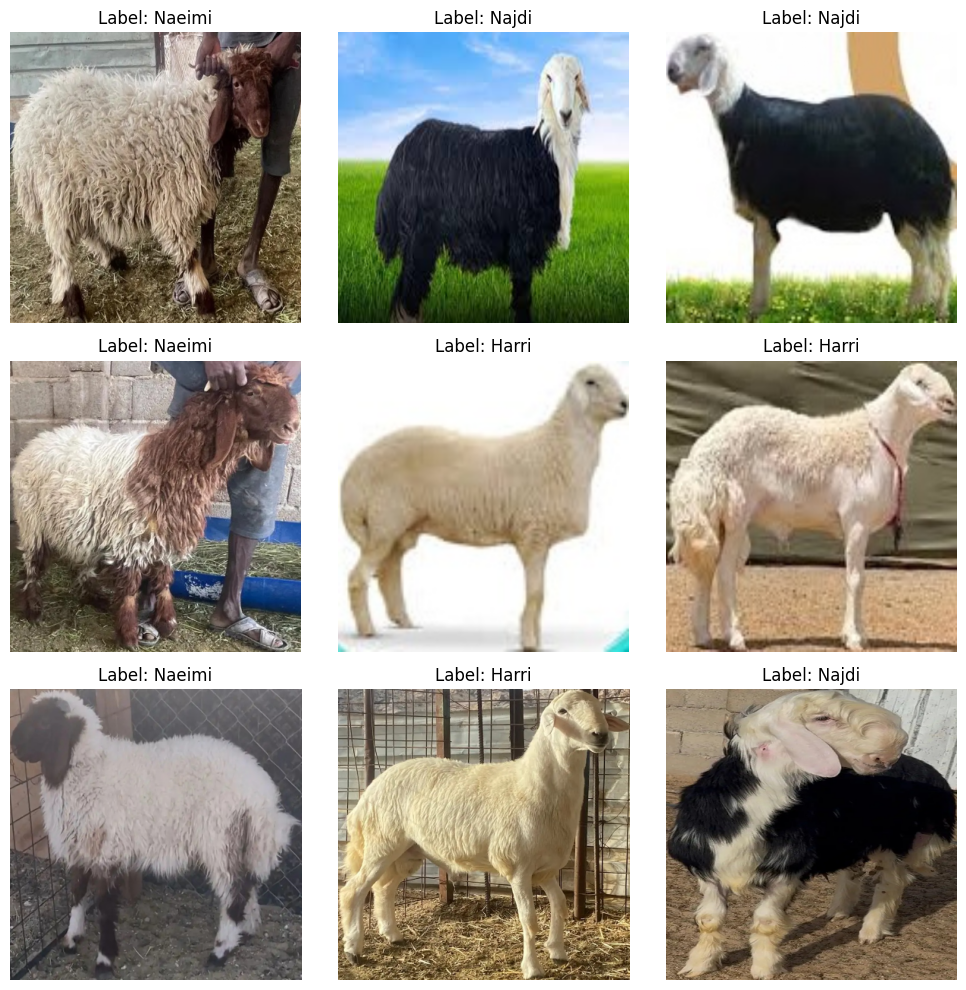

In [ ]:
num_images = 9
plt.figure(figsize=(10, 10))
for i in range(num_images):
    idx = np.random.randint(0, X_train.shape[0])
    img = X_train[idx]
    label = y_train[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

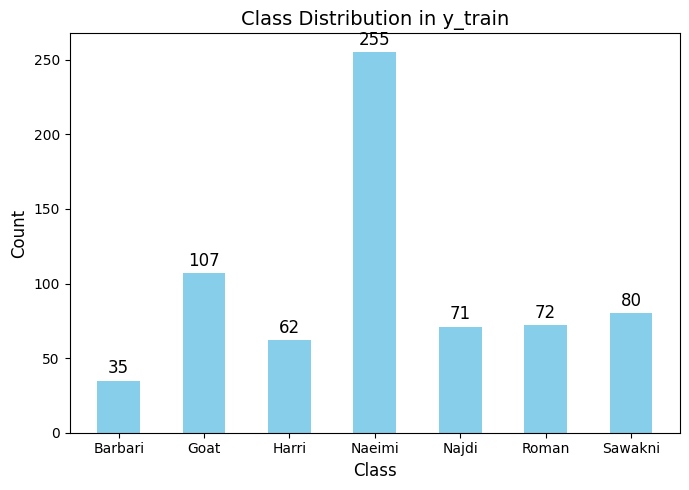

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(7, 5))
bars = plt.bar(unique, counts, color='skyblue', width=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=12)

plt.title('Class Distribution in y_train', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_ds = datagen.flow(
    X_train_split,
    y_train_split,
    batch_size=32,
    shuffle=True,
)

val_ds = ImageDataGenerator().flow(
    X_val_split,
    y_val_split,
    batch_size=32,
    shuffle=False
)

## Fine Tuning Using Efficient Net

In [ ]:
base_model = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(384, 384, 3),
    pooling='avg'
)

model = Sequential([
    base_model,
    Dense(7, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

I0000 00:00:1752581223.664649      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752581223.665315      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,340,327 (77.59 MB)

 Trainable params: 20,186,455 (77.01 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752581342.510251     104 service.cc:148] XLA service 0x7f385800b000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752581342.511627     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752581342.511656     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752581353.102403     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752581378.073703     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752581378.245946     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752581379.093894     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

18/18 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.6344 - loss: 1.0497 - val_accuracy: 0.0730 - val_loss: 4.0968 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 999ms/step - accuracy: 0.9247 - loss: 0.2740 - val_accuracy: 0.1898 - val_loss: 3.6633 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 992ms/step - accuracy: 0.9240 - loss: 0.2099 - val_accuracy: 0.0803 - val_loss: 3.2397 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 995ms/step - accuracy: 0.9270 - loss: 0.2359 - val_accuracy: 0.1971 - val_loss: 3.3179 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9419 - loss: 0.1729 - val_accuracy: 0.5985 - val_loss: 1.6810 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 953ms/step - accuracy: 0.9253 - loss: 0.2346 - val_accuracy: 0.3869 - val_loss: 2.3842 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9609 - loss: 0.1368 - val_accuracy

## Model Evaluation

In [ ]:
loss, acc = model.evaluate(val_ds)
print('Test accuracy:', acc)
print('Test loss:', loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.9640 - loss: 0.1399
Test accuracy: 0.9635036587715149
Test loss: 0.1392456740140915


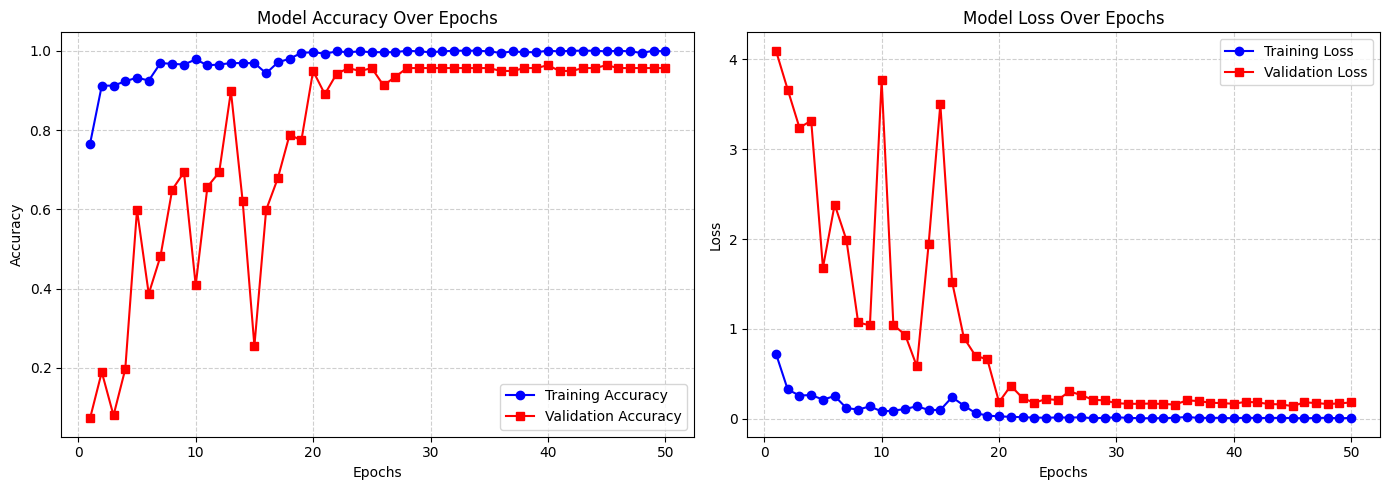

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
y_probs = model.predict(X_val_split)
y_pred = np.argmax(y_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step 


In [ ]:
print(classification_report(y_val_split, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231         6
           1     0.9630    0.9630    0.9630        27
           2     0.8182    0.9000    0.8571        10
           3     1.0000    0.9815    0.9907        54
           4     1.0000    1.0000    1.0000        14
           5     0.9000    1.0000    0.9474         9
           6     1.0000    0.8824    0.9375        17

    accuracy                         0.9635       137
   macro avg     0.9340    0.9610    0.9455       137
weighted avg     0.9666    0.9635    0.9640       137



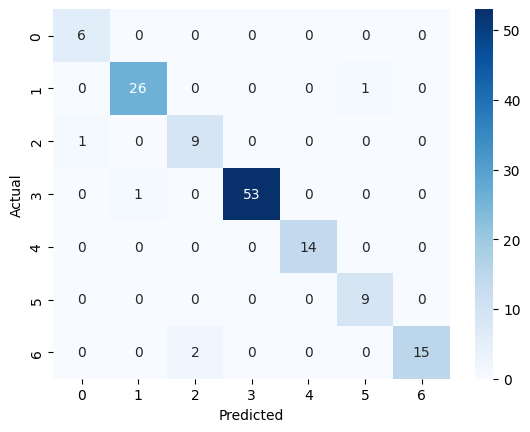

In [ ]:
conf_matrix = confusion_matrix(y_val_split, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Loading & Reading Test Images

In [ ]:
test_images = glob.glob('/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/*.jpg')

In [ ]:
len(test_images)

144

In [ ]:
X_test = []
for path in test_images:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384, 384))
    img = img.astype('float32') / 255.0
    X_test.append(img)

X_test = np.array(X_test)

## Predicting On Test Data & Submit Predictions

In [ ]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step  


In [ ]:
df_test = pd.DataFrame({
    'filename': [os.path.splitext(os.path.basename(p))[0] + '.jpg' for p in test_images],
    'label': y_pred_labels
})
df_test.head()

,filename,label
0,6d66297e.jpg,Sawakni
1,ed9f6250.jpg,Naeimi
2,30503f9d.jpg,Harri
3,74b88387.jpg,Goat
4,385082b9.jpg,Goat


In [ ]:
df_test.to_csv('submission.csv', index=False)